Preparing price data...
Fetching BTCUSDT...


C:\Users\redwan.khafif\AppData\Local\Temp\ipykernel_3868\3797671464.py:102: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  r = df.resample(target_freq).agg({


Fetching ETHUSDT...


C:\Users\redwan.khafif\AppData\Local\Temp\ipykernel_3868\3797671464.py:102: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  r = df.resample(target_freq).agg({
C:\Users\redwan.khafif\AppData\Local\Temp\ipykernel_3868\3797671464.py:166: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  if (last_rebalance is None) or (pd.Timestamp(t) >= last_rebalance + pd.Timedelta(REBALANCE_PERIOD)):
C:\Users\redwan.khafif\AppData\Local\Temp\ipykernel_3868\3797671464.py:262: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  periods_per_year = (365*24) / (pd.to_timedelta(TARGET_FREQ).total_seconds() / 3600)


Computing signals...
Computing volatility filter...
Running backtest...
Computing metrics...
Total return: 0.00%
Estimated annual return: 0.00%
Estimated Sharpe: nan
Max drawdown: 0.00%
Trades: 0


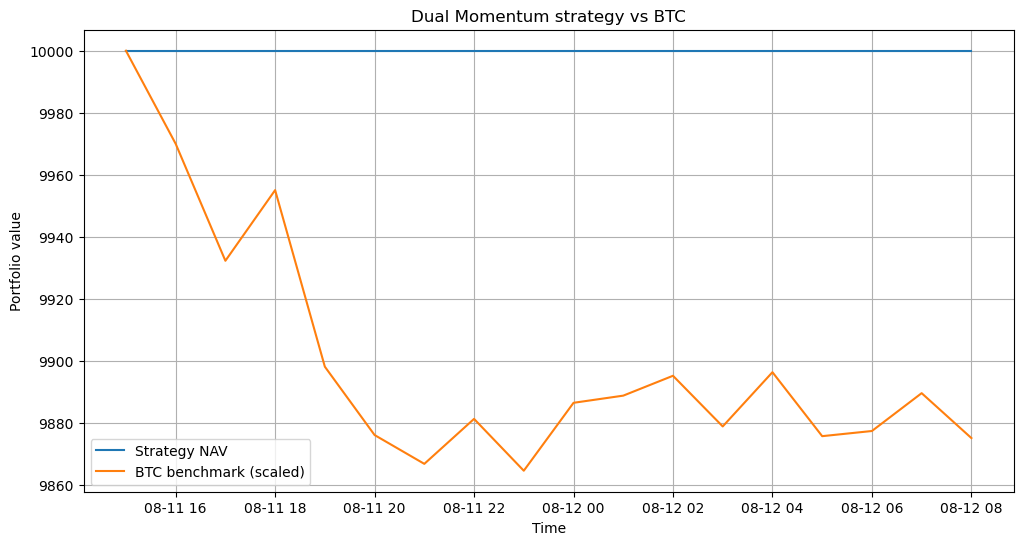

In [1]:
# dual_momentum_backtest.py
import math
import time
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# ---------------------------
# Parameters (tweakable)
# ---------------------------
SYMBOLS = ["BTCUSDT", "ETHUSDT"]
INTERVAL = "1m"            # fetch 1m and resample
TARGET_FREQ = "1H"         # backtest timeframe: '1H' or '4H', etc.
START = None               # e.g. '2025-05-01' or None for max
END = None                 # e.g. '2025-08-01' or None
ROLL_MOM_SHORT = 20        # short momentum window (in bars of TARGET_FREQ)
ROLL_MOM_LONG = 60         # long momentum window
RSI_LEN = 14
ATR_LEN = 14
VOL_LOOKBACK = 10          # for volatility filter (in TARGET_FREQ bars)
VOL_BASE = 60              # longer volatility baseline
BETA_THRESHOLD = None      # not used for dual momentum; left None
MAX_WEIGHT_PER_ASSET = 0.20  # max fraction of capital per asset
REBALANCE_PERIOD = "4H"    # how often to rebalance signals (string pandas offset)
STOP_ATR_MULT = 3.0        # stop loss at entry_price - STOP_ATR_MULT * ATR
INITIAL_CAPITAL = 10000.0
RISK_FREE_RATE = 0.0       # for Sharpe (annualized)
# ---------------------------

BINANCE_API = "https://api.binance.com"

def fetch_klines(symbol, interval, start_str=None, end_str=None, limit=1000):
    # returns DataFrame with datetimeindex and columns open, high, low, close, volume
    url = BINANCE_API + "/api/v3/klines"
    all_rows = []
    def to_ms(s):
        if s is None: return None
        return int(pd.to_datetime(s).timestamp() * 1000)
    start_ms = to_ms(start_str)
    end_ms = to_ms(end_str)
    while True:
        params = {"symbol": symbol, "interval": interval, "limit": limit}
        if start_ms: params["startTime"] = start_ms
        if end_ms: params["endTime"] = end_ms
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break
        all_rows += data
        if len(data) < limit:
            break
        last_open = int(data[-1][0])
        start_ms = last_open + 60_000
        time.sleep(0.2)
    if not all_rows:
        return pd.DataFrame()
    df = pd.DataFrame(all_rows, columns=[
        "open_time","open","high","low","close","volume","close_time",
        "qav","num_trades","taker_base","taker_quote","ignore"
    ])
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df.set_index("open_time", inplace=True)
    for col in ["open","high","low","close","volume"]:
        df[col] = df[col].astype(float)
    return df[["open","high","low","close","volume"]]

# ---------------------------
# Technical indicators
# ---------------------------
def rsi(series, length=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.ewm(alpha=1/length, adjust=False).mean()
    ma_down = down.ewm(alpha=1/length, adjust=False).mean()
    rs = ma_up / ma_down
    return 100 - (100 / (1 + rs))

def atr(df, length=14):
    high = df['high']
    low = df['low']
    close = df['close']
    tr = pd.concat([high - low, (high - close.shift()).abs(), (low - close.shift()).abs()], axis=1).max(axis=1)
    return tr.rolling(length).mean()

# ---------------------------
# Backtest engine (single run)
# ---------------------------
def prepare_prices(symbols, interval, target_freq, start=None, end=None):
    # fetch and resample each symbol, return dictionary of DataFrames aligned
    dfs = {}
    for s in symbols:
        print(f"Fetching {s}...")
        df = fetch_klines(s, interval, start_str=start, end_str=end)
        if df.empty:
            raise RuntimeError(f"No data for {s}")
        # resample to target_freq using OHLC for prices
        r = df.resample(target_freq).agg({
            "open":"first","high":"max","low":"min","close":"last","volume":"sum"
        }).ffill()
        dfs[s] = r
    # align indices
    idx = dfs[symbols[0]].index
    for s in symbols[1:]:
        idx = idx.intersection(dfs[s].index)
    for s in symbols:
        dfs[s] = dfs[s].reindex(idx).ffill()
    return dfs

def compute_signals(dfs):
    # compute indicators and signals for each asset (momentum + rsi + atr)
    signals = {}
    for s, df in dfs.items():
        price = df['close']
        mom_short = price.pct_change(periods=ROLL_MOM_SHORT)
        mom_long = price.pct_change(periods=ROLL_MOM_LONG)
        rsi_val = rsi(price, RSI_LEN)
        atr_val = atr(df, ATR_LEN)
        # signal = 1 if both momentum positive, else 0 (no shorts here)
        mom_signal = ((mom_short > 0) & (mom_long > 0)).astype(int)
        # store
        signals[s] = pd.DataFrame({
            "price": price,
            "mom_short": mom_short,
            "mom_long": mom_long,
            "mom_signal": mom_signal,
            "rsi": rsi_val,
            "atr": atr_val
        })
    return signals

def volatility_filter(dfs_signals):
    # compute realized vol (std of returns) short vs base; returns boolean mask per timestamp
    vol_masks = {}
    for s, df in dfs_signals.items():
        returns = df['price'].pct_change().fillna(0)
        vol_short = returns.rolling(VOL_LOOKBACK).std()
        vol_base = returns.rolling(VOL_BASE).std()
        # mask True when short vol > base vol (i.e. trending/higher vol)
        vol_masks[s] = (vol_short > vol_base)
    # global mask = at least one asset passes the vol filter (or require both?)
    # here require that the market (BTC) passes the vol filter to trade
    global_mask = vol_masks.get("BTCUSDT", pd.Series(False, index=list(dfs_signals.values())[0].index))
    return global_mask, vol_masks

def backtest(dfs_signals, global_vol_mask):
    timestamps = list(next(iter(dfs_signals.values())).index)
    capital = INITIAL_CAPITAL
    cash = capital
    positions = {s: 0.0 for s in dfs_signals.keys()}  # number of contracts/shares (units)
    entry_prices = {s: np.nan for s in dfs_signals.keys()}
    equity_hist = []
    nav_index = []
    trades = []

    last_rebalance = None

    for t in timestamps:
        # Rebalance only at multiples of REBALANCE_PERIOD if set, otherwise every bar
        do_rebalance = True
        if REBALANCE_PERIOD:
            if (last_rebalance is None) or (pd.Timestamp(t) >= last_rebalance + pd.Timedelta(REBALANCE_PERIOD)):
                do_rebalance = True
                last_rebalance = pd.Timestamp(t)
            else:
                do_rebalance = False

        if do_rebalance and global_vol_mask.loc[t]:
            # build candidate signals across assets
            # compute a raw score = zscore of short momentum * mom_signal * rsi filter
            scores = {}
            for s, df in dfs_signals.items():
                row = df.loc[t]
                if np.isnan(row['mom_short']) or np.isnan(row['mom_long']):
                    scores[s] = 0.0
                    continue
                if row['mom_signal'] == 0:
                    scores[s] = 0.0
                    continue
                # signal strength = short mom normalized by long mom magnitude (zscore approach)
                # fallback: use mom_short value
                scores[s] = float(row['mom_short'])
                # RSI reinforcement: if RSI between 30 and 70 -> neutral; if <30 -> increase weight; >70 decrease
                if row['rsi'] < 30:
                    scores[s] *= 1.2
                elif row['rsi'] > 70:
                    scores[s] *= 0.8

            # normalize positive scores to weights (only long signals)
            positives = {s: v for s, v in scores.items() if v > 0}
            if positives:
                sum_pos = sum(positives.values())
                # allocate up to MAX_WEIGHT_PER_ASSET proportionally
                for s, v in positives.items():
                    target_weight = (v / sum_pos) * min(MAX_WEIGHT_PER_ASSET * len(positives), 1.0)
                    # compute target dollar allocation
                    target_value = target_weight * capital
                    price = dfs_signals[s].loc[t, "price"]
                    target_units = target_value / price
                    # adjust position: buy/sell to target (here only buy/close)
                    current_units = positions[s]
                    if target_units > current_units:
                        # buy incremental
                        buy_units = target_units - current_units
                        cost = buy_units * price
                        if cost > cash:
                            buy_units = cash / price
                            cost = buy_units * price
                        if buy_units > 0:
                            cash -= cost
                            positions[s] += buy_units
                            entry_prices[s] = price
                            trades.append({"time": t, "symbol": s, "side": "BUY", "units": buy_units, "price": price})
                    elif target_units < current_units:
                        # reduce position
                        sell_units = current_units - target_units
                        proceeds = sell_units * price
                        cash += proceeds
                        positions[s] -= sell_units
                        trades.append({"time": t, "symbol": s, "side": "SELL", "units": sell_units, "price": price})
        # check stops and take-profits each bar
        for s, df in dfs_signals.items():
            if positions[s] > 0:
                cur_price = df.loc[t, "price"]
                entry = entry_prices[s]
                cur_atr = df.loc[t, "atr"] if not np.isnan(df.loc[t,"atr"]) else 0.0
                # stop based on ATR
                if not np.isnan(entry) and cur_atr > 0:
                    stop_price = entry - STOP_ATR_MULT * cur_atr * entry  # approximate since atr is in log-returns
                    if cur_price <= stop_price:
                        # close position
                        proceeds = positions[s] * cur_price
                        cash += proceeds
                        trades.append({"time": t, "symbol": s, "side": "STOP", "units": positions[s], "price": cur_price})
                        positions[s] = 0.0
                        entry_prices[s] = np.nan
                # simple take profit: if returns since entry > 5% (example), close
                if not np.isnan(entry) and (cur_price / entry - 1.0) >= 0.05:
                    proceeds = positions[s] * cur_price
                    cash += proceeds
                    trades.append({"time": t, "symbol": s, "side": "TP", "units": positions[s], "price": cur_price})
                    positions[s] = 0.0
                    entry_prices[s] = np.nan

        # compute NAV
        nav = cash + sum(positions[s] * dfs_signals[s].loc[t, "price"] for s in positions)
        equity_hist.append(nav)
        nav_index.append(t)

    equity = pd.Series(equity_hist, index=pd.to_datetime(nav_index))
    trades_df = pd.DataFrame(trades)
    return equity, trades_df

def metrics_from_equity(equity):
    returns = equity.pct_change().dropna()
    total_return = equity.iloc[-1] / equity.iloc[0] - 1.0
    # annualize on 365 days; but timeframe arbitrary -> convert periods per year:
    periods_per_year = (365*24) / (pd.to_timedelta(TARGET_FREQ).total_seconds() / 3600)
    ann_return = (1 + total_return) ** (periods_per_year / len(equity)) - 1
    ann_vol = returns.std() * math.sqrt(periods_per_year)
    sharpe = (returns.mean() * periods_per_year - RISK_FREE_RATE) / (returns.std() * math.sqrt(periods_per_year)) if returns.std() > 0 else np.nan
    # max drawdown
    cummax = equity.cummax()
    drawdown = (equity - cummax) / cummax
    max_dd = drawdown.min()
    return {
        "total_return": total_return,
        "annual_return_approx": ann_return,
        "annual_vol_approx": ann_vol,
        "sharpe_approx": sharpe,
        "max_drawdown": max_dd
    }

# ---------------------------
# Run everything
# ---------------------------
def main():
    print("Preparing price data...")
    dfs = prepare_prices(SYMBOLS, INTERVAL, TARGET_FREQ, start=START, end=END)
    print("Computing signals...")
    signals = compute_signals(dfs)
    print("Computing volatility filter...")
    global_mask, vol_masks = volatility_filter(signals)
    print("Running backtest...")
    equity, trades = backtest(signals, global_mask)
    print("Computing metrics...")
    m = metrics_from_equity(equity)
    print(f"Total return: {m['total_return']*100:.2f}%")
    print(f"Estimated annual return: {m['annual_return_approx']*100:.2f}%")
    print(f"Estimated Sharpe: {m['sharpe_approx']:.2f}")
    print(f"Max drawdown: {m['max_drawdown']*100:.2f}%")
    print(f"Trades: {len(trades)}")

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(equity, label="Strategy NAV")
    # plot BTC benchmark
    btc_price = dfs["BTCUSDT"]["close"]
    btc_ret = (btc_price / btc_price.iloc[0]) * INITIAL_CAPITAL
    btc_ret = btc_ret.reindex(equity.index).ffill()
    plt.plot(btc_ret, label="BTC benchmark (scaled)")
    plt.legend()
    plt.title("Dual Momentum strategy vs BTC")
    plt.xlabel("Time")
    plt.ylabel("Portfolio value")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
